In [1]:
from rdkit import Chem
import sys
import os
import useful_rdkit_utils as uru
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import itertools
import pandas as pd
from collections import Counter
import mols2grid
from tdc.single_pred import ADME
from Filtering_functions import filter_molecules
import glob
import molvs
from multiprocessing import Pool, cpu_count
from tqdm.auto import tqdm

In [2]:
# Get the current working directory
current_dir = os.getcwd()
print(current_dir)
# Get the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
print(parent_dir)
# Add the parent directory to sys.path
sys.path.append(parent_dir)

/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7cky/molsnapper/use_pharma_true
/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7cky/molsnapper


Reading data from crossdock dataset, add a standardization for small molecule data:

In [3]:
standardizer = molvs.standardize.Standardizer()

def standardize_mol(mol):
    try:
        mol = standardizer.standardize(mol)
        mol = standardizer.fragment_parent(mol, skip_standardize=True)
        mol = standardizer.tautomer_parent(mol, skip_standardize=True)
        mol = standardizer.isotope_parent(mol, skip_standardize=True)
        mol = standardizer.charge_parent(mol, skip_standardize=True)
        return mol
    except:
        return None

In [4]:
smi_list = []
with open('/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/three_proteins/7cky/molsnapper/use_pharma_true/500_generated.smi') as f:
    for smi in f:
        smi_list.append(smi.strip())
standardized_smiles_list = []
for smi in tqdm(smi_list, desc="Standardizing molecules", unit="mol"):
    mol = Chem.MolFromSmiles(smi)
    mol = standardize_mol(mol)
    
    if mol:
        standardized_smiles_list.append(Chem.MolToSmiles(mol))
    else:
        print(f"Skipping molecule {smi}")
        pass

print(len(smi_list))
len(standardized_smiles_list)

Standardizing molecules:   0%|          | 0/501 [00:00<?, ?mol/s]

[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 30
[16:24:46] Can't kekulize mol.  Unkekulized atoms: 1 20 

501


501

Set the default image size

In [5]:
with open('500_generated_standardized.smi', 'w') as f:
    for item in standardized_smiles_list:
        f.write("%s\n" % item)

In [6]:
uru.rd_set_image_size(300,300)

Convert SMILES and name of them to a dataframe

In [7]:
df = pd.DataFrame(standardized_smiles_list, columns=['SMILES'])
df

,SMILES
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...
4,O=C(Nc1ccc([N+]23C(=O)C2(C(=O)N=c2ncc(Cl)c[nH]...
...,...
496,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...
497,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...
498,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...
499,COC1CCC2NC(c3ccc(NC(=O)C4CCN(C5NNC(C)N5)CCO4)c...


Remove repeated molecules

In [8]:
df = df.drop_duplicates(['SMILES'])
df.reset_index(inplace=True, drop=True)
df

,SMILES
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...
4,O=C(Nc1ccc([N+]23C(=O)C2(C(=O)N=c2ncc(Cl)c[nH]...
...,...
486,O=c1[nH]c2ncnn2nnc2cc3oc(-c4ccco4)nc3cc2oc2ccc...
487,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...
488,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...
489,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...


Save the smi file for further use

Add an RDKit molecule to the dataframe

In [9]:
df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

Strip salts from the molecule

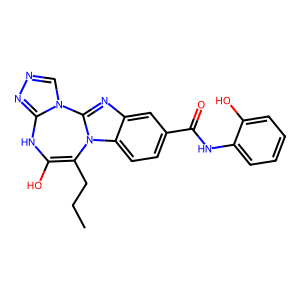

In [10]:
df.mol = df.mol.apply(uru.get_largest_fragment)
df.mol[0]

Instantiate a RingSystemFinder object and find ring systems for the molecules in df

In [11]:
ring_system_finder = uru.RingSystemFinder()
df['ring_sytems'] = df.mol.apply(ring_system_finder.find_ring_systems)
df.ring_sytems

0             [c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, c1ccccc1]
1      [C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, c1ccoc1]
2          [C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15]
3            [O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, c1ccoc1]
4      [c1ccccc1, O=C1C2C3CC3[NH+]12, N=c1nccc[nH]1, ...
                             ...                        
486    [O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, c1c...
487       [C1NCNN1, c1ccc2c(c1)N2, c1ccc2c(c1)nc1n2CCC1]
488           [c1ccccc1, c1ccccc1, c1c[nH]nn1, c1ccccc1]
489           [N=c1nccc[nH]1, c1ccccc1, C1NCO1, c1ccoc1]
490         [C1CC2NCOC2C1, c1ccccc1, C1CNCCOC1, C1NCNN1]
Name: ring_sytems, Length: 491, dtype: object

In [12]:
df.ring_sytems.values

array([list(['c1ccc2c(c1)nc1n3cnnc3[nH]ccn21', 'c1ccccc1']),
       list(['C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1', 'c1ccoc1']),
       list(['C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15']),
       list(['O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12', 'c1ccoc1']),
       list(['c1ccccc1', 'O=C1C2C3CC3[NH+]12', 'N=c1nccc[nH]1', 'c1ccoc1']),
       list(['O=C1NCNC2NC3CC4OC=NC4CC3NC(=O)C12', 'c1ccccc1']),
       list(['O=C1NC2NNC3CC(NN32)C2CC(COC3CCC1CC3)C1NCOC1C2', 'c1ccoc1']),
       list(['O=C1C2CC3N=COC3CC2OC2NCNCC12', 'c1ccoc1', 'c1ccccc1']),
       list(['C1NCNN1', 'c1ccccc1', 'c1ccc2ocnc2c1', 'c1ccoc1']),
       list(['c1ccccc1', 'c1ccccc1', 'N=c1nc[nH][nH]1', 'c1ccccc1']),
       list(['O=C1COC2CCC3C4NCOC4CC4ON5CNC(N1)N5C2C43', 'c1ccoc1']),
       list(['N=c1[nH]cn[nH]1', 'c1ccccc1', 'C1NCO1', 'c1ccoc1', 'c1ccccc1']),
       list(['c1ccccc1', 'O=c1[nH]nc2ncccn12', 'c1ccccc1']),
       list(['c1ccoc1', 'c1ccccc1', 'O=C1NCCc2nnccc21', 'C1NCNN1']),
       list(['C1NCNN1', 'c1ccccc1', 'C1=Nc2cccc

See how many times each ring system occurs

In [13]:
ring_system_list = list(itertools.chain.from_iterable(df.ring_sytems.values))
ring_count_df = pd.DataFrame(Counter(ring_system_list).items(),columns=["SMILES","Count"]) ### Convert a dictionary to a DataFrame.
ring_count_df.sort_values("Count",ascending=False,inplace=True)
ring_count_df

,SMILES,Count
1,c1ccccc1,438
3,c1ccoc1,255
11,C1NCNN1,73
12,c1ccc2ocnc2c1,58
7,N=c1nccc[nH]1,17
...,...,...
156,C1=NC2CC3CC4CNC5NCCCN5C4OC3CC2O1,1
155,C1CNNN1,1
153,N=c1nc2nc3ccccc3nc2c[nH]1,1
152,O=C1NCNCN2C3C1CNC1CCCCC1N32,1


View the ring system frequencies

In [14]:
mols2grid.display(ring_count_df,subset=["img","Count"])

MolGridWidget()

The RingSystemLookup object has a dictionary of how many times each ring system occurs in the ChEMBL database.  We can use this object to evaluate the molecules in df.

In [15]:
ring_system_lookup = uru.RingSystemLookup()
res = df.mol.apply(ring_system_lookup.process_mol)

In [16]:
res

0      [(c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, 0), (c1ccccc...
1      [(C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, 0), ...
2      [(C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,...
3      [(O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, 0), (c1cco...
4      [(c1ccccc1, 2568039), (O=C1C2C3CC3[NH+]12, 0),...
                             ...                        
486    [(O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, 0)...
487    [(C1NCNN1, 1), (c1ccc2c(c1)N2, 0), (c1ccc2c(c1...
488    [(c1ccccc1, 2568039), (c1ccccc1, 2568039), (c1...
489    [(N=c1nccc[nH]1, 16), (c1ccccc1, 2568039), (C1...
490    [(C1CC2NCOC2C1, 0), (c1ccccc1, 2568039), (C1CN...
Name: mol, Length: 491, dtype: object

In [17]:
df[['min_ring','min_freq']] = res.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4120>,"[c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, c1ccccc1]",c1ccc2c(c1)nc1n3cnnc3[nH]ccn21,0
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4190>,"[C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, c1ccoc1]",C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1,0
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4200>,[C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15],C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,0
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4270>,"[O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, c1ccoc1]",O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12,0
4,O=C(Nc1ccc([N+]23C(=O)C2(C(=O)N=c2ncc(Cl)c[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e42e0>,"[c1ccccc1, O=C1C2C3CC3[NH+]12, N=c1nccc[nH]1, ...",O=C1C2C3CC3[NH+]12,0
...,...,...,...,...,...
486,O=c1[nH]c2ncnn2nnc2cc3oc(-c4ccco4)nc3cc2oc2ccc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621620>,"[O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, c1c...",O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2,0
487,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621690>,"[C1NCNN1, c1ccc2c(c1)N2, c1ccc2c(c1)nc1n2CCC1]",c1ccc2c(c1)N2,0
488,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621700>,"[c1ccccc1, c1ccccc1, c1c[nH]nn1, c1ccccc1]",c1c[nH]nn1,41492
489,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621770>,"[N=c1nccc[nH]1, c1ccccc1, C1NCO1, c1ccoc1]",C1NCO1,2


In [18]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

### Check how many molecules are unique the ring frequency of them

How many molecules are unique using inChI?

In [19]:
df['inchi'] = df.mol.apply(Chem.MolToInchi)
df = df.drop_duplicates("inchi", keep="first", ignore_index=True)
df

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Proton(s) added/removed; Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06] WARNING: Omitted undefined stereo

[16:26:06

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4120>,"[c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, c1ccccc1]",c1ccc2c(c1)nc1n3cnnc3[nH]ccn21,0,InChI=1S/C21H19N7O3/c1-2-5-16-19(31)25-20-26-2...
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4190>,"[C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, c1ccoc1]",C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1,0,InChI=1S/C22H33N5O3/c1-11-23-20-22(26-25-11)30...
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4200>,[C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15],C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,0,InChI=1S/C23H39N5O3/c1-11-26-27-22-23(29)8-4-5...
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4270>,"[O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, c1ccoc1]",O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12,0,InChI=1S/C21H30N6O4/c1-3-26-20(30)16-17(28)13-...
4,O=C(Nc1ccc([N+]23C(=O)C2(C(=O)N=c2ncc(Cl)c[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e42e0>,"[c1ccccc1, O=C1C2C3CC3[NH+]12, N=c1nccc[nH]1, ...",O=C1C2C3CC3[NH+]12,0,InChI=1S/C21H14ClN5O4/c22-11-9-23-20(24-10-11)...
...,...,...,...,...,...,...
486,O=c1[nH]c2ncnn2nnc2cc3oc(-c4ccco4)nc3cc2oc2ccc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621620>,"[O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, c1c...",O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2,0,InChI=1S/C20H11N7O4/c28-18-11-3-1-4-12(7-11)30...
487,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621690>,"[C1NCNN1, c1ccc2c(c1)N2, c1ccc2c(c1)nc1n2CCC1]",c1ccc2c(c1)N2,0,InChI=1S/C20H21N7O3S/c1-11-21-20(24-23-11)25-3...
488,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621700>,"[c1ccccc1, c1ccccc1, c1c[nH]nn1, c1ccccc1]",c1c[nH]nn1,41492,InChI=1S/C23H22N4O3/c1-30-19-9-5-8-18(14-19)24...
489,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621770>,"[N=c1nccc[nH]1, c1ccccc1, C1NCO1, c1ccoc1]",C1NCO1,2,InChI=1S/C22H23N5O4/c1-13(19(29)26-22-23-10-9-...


How many of them have ring system?

In [20]:
df_ring = df[df.min_freq != -1]
df_ring

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4120>,"[c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, c1ccccc1]",c1ccc2c(c1)nc1n3cnnc3[nH]ccn21,0,InChI=1S/C21H19N7O3/c1-2-5-16-19(31)25-20-26-2...
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4190>,"[C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, c1ccoc1]",C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1,0,InChI=1S/C22H33N5O3/c1-11-23-20-22(26-25-11)30...
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4200>,[C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15],C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,0,InChI=1S/C23H39N5O3/c1-11-26-27-22-23(29)8-4-5...
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4270>,"[O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, c1ccoc1]",O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12,0,InChI=1S/C21H30N6O4/c1-3-26-20(30)16-17(28)13-...
4,O=C(Nc1ccc([N+]23C(=O)C2(C(=O)N=c2ncc(Cl)c[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e42e0>,"[c1ccccc1, O=C1C2C3CC3[NH+]12, N=c1nccc[nH]1, ...",O=C1C2C3CC3[NH+]12,0,InChI=1S/C21H14ClN5O4/c22-11-9-23-20(24-10-11)...
...,...,...,...,...,...,...
486,O=c1[nH]c2ncnn2nnc2cc3oc(-c4ccco4)nc3cc2oc2ccc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621620>,"[O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, c1c...",O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2,0,InChI=1S/C20H11N7O4/c28-18-11-3-1-4-12(7-11)30...
487,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621690>,"[C1NCNN1, c1ccc2c(c1)N2, c1ccc2c(c1)nc1n2CCC1]",c1ccc2c(c1)N2,0,InChI=1S/C20H21N7O3S/c1-11-21-20(24-23-11)25-3...
488,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621700>,"[c1ccccc1, c1ccccc1, c1c[nH]nn1, c1ccccc1]",c1c[nH]nn1,41492,InChI=1S/C23H22N4O3/c1-30-19-9-5-8-18(14-19)24...
489,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621770>,"[N=c1nccc[nH]1, c1ccccc1, C1NCO1, c1ccoc1]",C1NCO1,2,InChI=1S/C22H23N5O4/c1-13(19(29)26-22-23-10-9-...


In [22]:
filtered_df_ring_freq = df[df.min_freq > 100]
len(filtered_df_ring_freq)

20

### How many of them could pass PAINS filter?

Get a list of rules

In [23]:
reos = uru.REOS()
reos.get_available_rule_sets()

array(['Glaxo', 'Dundee', 'BMS', 'PAINS', 'SureChEMBL', 'MLSMR',
       'Inpharmatica', 'LINT'], dtype=object)

Get the currently active rule sets

In [24]:
reos.get_active_rule_sets()

array(['Glaxo'], dtype=object)

Set active rule set to PAINS

In [25]:
reos.set_active_rule_sets(['PAINS'])
reos.get_active_rule_sets()

array(['PAINS'], dtype=object)

Apply PAINS filter to unique mols

In [26]:
reos.pandas_mols(df.mol)

  0%|          | 0/491 [00:00<?, ?it/s]

,rule_set_name,description
0,ok,ok
1,ok,ok
2,ok,ok
3,ok,ok
4,ok,ok
...,...,...
486,ok,ok
487,ok,ok
488,ok,ok
489,ok,ok


In [27]:
df_PAINS_filter = pd.concat([df, reos.pandas_mols(df.mol)], axis=1)
df_PAINS_filter = df_PAINS_filter[df_PAINS_filter.description == 'ok']
df_PAINS_filter

  0%|          | 0/491 [00:00<?, ?it/s]

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,rule_set_name,description
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4120>,"[c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, c1ccccc1]",c1ccc2c(c1)nc1n3cnnc3[nH]ccn21,0,InChI=1S/C21H19N7O3/c1-2-5-16-19(31)25-20-26-2...,ok,ok
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4190>,"[C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, c1ccoc1]",C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1,0,InChI=1S/C22H33N5O3/c1-11-23-20-22(26-25-11)30...,ok,ok
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4200>,[C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15],C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,0,InChI=1S/C23H39N5O3/c1-11-26-27-22-23(29)8-4-5...,ok,ok
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4270>,"[O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, c1ccoc1]",O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12,0,InChI=1S/C21H30N6O4/c1-3-26-20(30)16-17(28)13-...,ok,ok
4,O=C(Nc1ccc([N+]23C(=O)C2(C(=O)N=c2ncc(Cl)c[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e42e0>,"[c1ccccc1, O=C1C2C3CC3[NH+]12, N=c1nccc[nH]1, ...",O=C1C2C3CC3[NH+]12,0,InChI=1S/C21H14ClN5O4/c22-11-9-23-20(24-10-11)...,ok,ok
...,...,...,...,...,...,...,...,...
486,O=c1[nH]c2ncnn2nnc2cc3oc(-c4ccco4)nc3cc2oc2ccc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621620>,"[O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, c1c...",O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2,0,InChI=1S/C20H11N7O4/c28-18-11-3-1-4-12(7-11)30...,ok,ok
487,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621690>,"[C1NCNN1, c1ccc2c(c1)N2, c1ccc2c(c1)nc1n2CCC1]",c1ccc2c(c1)N2,0,InChI=1S/C20H21N7O3S/c1-11-21-20(24-23-11)25-3...,ok,ok
488,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621700>,"[c1ccccc1, c1ccccc1, c1c[nH]nn1, c1ccccc1]",c1c[nH]nn1,41492,InChI=1S/C23H22N4O3/c1-30-19-9-5-8-18(14-19)24...,ok,ok
489,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621770>,"[N=c1nccc[nH]1, c1ccccc1, C1NCO1, c1ccoc1]",C1NCO1,2,InChI=1S/C22H23N5O4/c1-13(19(29)26-22-23-10-9-...,ok,ok


Test all filters from rd filters

In [28]:
rd_filters = ['Glaxo', 'Dundee', 'BMS', 'SureChEMBL', 'MLSMR', 'Inpharmatica', 'LINT']
for filter in rd_filters:
    reos.set_active_rule_sets([filter])
    new_df = reos.pandas_mols(df.mol)
    print(filter, len(new_df[new_df.description == "ok"])/len(new_df), reos.get_active_rule_sets(), len(new_df[new_df.description == "ok"]))

  0%|          | 0/491 [00:00<?, ?it/s]

Glaxo 0.9063136456211812 ['Glaxo'] 445


  0%|          | 0/491 [00:00<?, ?it/s]

Dundee 0.5784114052953157 ['Dundee'] 284


  0%|          | 0/491 [00:00<?, ?it/s]

BMS 0.43380855397148677 ['BMS'] 213


  0%|          | 0/491 [00:00<?, ?it/s]

SureChEMBL 0.8105906313645621 ['SureChEMBL'] 398


  0%|          | 0/491 [00:00<?, ?it/s]

MLSMR 0.48065173116089616 ['MLSMR'] 236


  0%|          | 0/491 [00:00<?, ?it/s]

Inpharmatica 0.45010183299389 ['Inpharmatica'] 221


  0%|          | 0/491 [00:00<?, ?it/s]

LINT 0.7637474541751528 ['LINT'] 375


### How many of them could pass filters suggested by Dr.Reymond?

In [29]:
df['Reymond'] = df.mol.apply(filter_molecules)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4120>,"[c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, c1ccccc1]",c1ccc2c(c1)nc1n3cnnc3[nH]ccn21,0,InChI=1S/C21H19N7O3/c1-2-5-16-19(31)25-20-26-2...,True
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4190>,"[C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, c1ccoc1]",C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1,0,InChI=1S/C22H33N5O3/c1-11-23-20-22(26-25-11)30...,True
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4200>,[C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15],C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,0,InChI=1S/C23H39N5O3/c1-11-26-27-22-23(29)8-4-5...,True
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4270>,"[O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, c1ccoc1]",O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12,0,InChI=1S/C21H30N6O4/c1-3-26-20(30)16-17(28)13-...,True
4,O=C(Nc1ccc([N+]23C(=O)C2(C(=O)N=c2ncc(Cl)c[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e42e0>,"[c1ccccc1, O=C1C2C3CC3[NH+]12, N=c1nccc[nH]1, ...",O=C1C2C3CC3[NH+]12,0,InChI=1S/C21H14ClN5O4/c22-11-9-23-20(24-10-11)...,False
...,...,...,...,...,...,...,...
486,O=c1[nH]c2ncnn2nnc2cc3oc(-c4ccco4)nc3cc2oc2ccc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621620>,"[O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, c1c...",O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2,0,InChI=1S/C20H11N7O4/c28-18-11-3-1-4-12(7-11)30...,True
487,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621690>,"[C1NCNN1, c1ccc2c(c1)N2, c1ccc2c(c1)nc1n2CCC1]",c1ccc2c(c1)N2,0,InChI=1S/C20H21N7O3S/c1-11-21-20(24-23-11)25-3...,True
488,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621700>,"[c1ccccc1, c1ccccc1, c1c[nH]nn1, c1ccccc1]",c1c[nH]nn1,41492,InChI=1S/C23H22N4O3/c1-30-19-9-5-8-18(14-19)24...,True
489,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621770>,"[N=c1nccc[nH]1, c1ccccc1, C1NCO1, c1ccoc1]",C1NCO1,2,InChI=1S/C22H23N5O4/c1-13(19(29)26-22-23-10-9-...,True


In [30]:
df_Reymond_filter = df[df.Reymond == True]
df_Reymond_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4120>,"[c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, c1ccccc1]",c1ccc2c(c1)nc1n3cnnc3[nH]ccn21,0,InChI=1S/C21H19N7O3/c1-2-5-16-19(31)25-20-26-2...,True
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4190>,"[C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, c1ccoc1]",C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1,0,InChI=1S/C22H33N5O3/c1-11-23-20-22(26-25-11)30...,True
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4200>,[C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15],C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,0,InChI=1S/C23H39N5O3/c1-11-26-27-22-23(29)8-4-5...,True
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4270>,"[O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, c1ccoc1]",O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12,0,InChI=1S/C21H30N6O4/c1-3-26-20(30)16-17(28)13-...,True
5,CCNC1NC(=O)C2C(=O)NC3CC4N=C(c5ccccc5OC)OC4CC3N...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4350>,"[O=C1NCNC2NC3CC4OC=NC4CC3NC(=O)C12, c1ccccc1]",O=C1NCNC2NC3CC4OC=NC4CC3NC(=O)C12,0,InChI=1S/C21H28N6O4/c1-3-22-21-26-17-16(19(29)...,True
...,...,...,...,...,...,...,...
486,O=c1[nH]c2ncnn2nnc2cc3oc(-c4ccco4)nc3cc2oc2ccc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621620>,"[O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, c1c...",O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2,0,InChI=1S/C20H11N7O4/c28-18-11-3-1-4-12(7-11)30...,True
487,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621690>,"[C1NCNN1, c1ccc2c(c1)N2, c1ccc2c(c1)nc1n2CCC1]",c1ccc2c(c1)N2,0,InChI=1S/C20H21N7O3S/c1-11-21-20(24-23-11)25-3...,True
488,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621700>,"[c1ccccc1, c1ccccc1, c1c[nH]nn1, c1ccccc1]",c1c[nH]nn1,41492,InChI=1S/C23H22N4O3/c1-30-19-9-5-8-18(14-19)24...,True
489,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621770>,"[N=c1nccc[nH]1, c1ccccc1, C1NCO1, c1ccoc1]",C1NCO1,2,InChI=1S/C22H23N5O4/c1-13(19(29)26-22-23-10-9-...,True


### How many of them could pass RO5?

In [31]:
def passes_rule_of_five(smiles):
    """Determine if a molecule passes Lipinski's Rule of Five."""
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen bond donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen bond acceptors
        mw = Descriptors.MolWt(mol)  # Molecular weight
        logp = Descriptors.MolLogP(mol)  # LogP
        
        # Check Lipinski's Rule of Five criteria
        if hbd <= 5 and hba <= 10 and mw <= 500 and logp <= 5:
            return True
    return False

df['Lipinski'] = df.SMILES.apply(passes_rule_of_five)
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4120>,"[c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, c1ccccc1]",c1ccc2c(c1)nc1n3cnnc3[nH]ccn21,0,InChI=1S/C21H19N7O3/c1-2-5-16-19(31)25-20-26-2...,True,True
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4190>,"[C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, c1ccoc1]",C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1,0,InChI=1S/C22H33N5O3/c1-11-23-20-22(26-25-11)30...,True,True
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4200>,[C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15],C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,0,InChI=1S/C23H39N5O3/c1-11-26-27-22-23(29)8-4-5...,True,True
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4270>,"[O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, c1ccoc1]",O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12,0,InChI=1S/C21H30N6O4/c1-3-26-20(30)16-17(28)13-...,True,True
4,O=C(Nc1ccc([N+]23C(=O)C2(C(=O)N=c2ncc(Cl)c[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e42e0>,"[c1ccccc1, O=C1C2C3CC3[NH+]12, N=c1nccc[nH]1, ...",O=C1C2C3CC3[NH+]12,0,InChI=1S/C21H14ClN5O4/c22-11-9-23-20(24-10-11)...,False,True
...,...,...,...,...,...,...,...,...
486,O=c1[nH]c2ncnn2nnc2cc3oc(-c4ccco4)nc3cc2oc2ccc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621620>,"[O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, c1c...",O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2,0,InChI=1S/C20H11N7O4/c28-18-11-3-1-4-12(7-11)30...,True,True
487,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621690>,"[C1NCNN1, c1ccc2c(c1)N2, c1ccc2c(c1)nc1n2CCC1]",c1ccc2c(c1)N2,0,InChI=1S/C20H21N7O3S/c1-11-21-20(24-23-11)25-3...,True,True
488,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621700>,"[c1ccccc1, c1ccccc1, c1c[nH]nn1, c1ccccc1]",c1c[nH]nn1,41492,InChI=1S/C23H22N4O3/c1-30-19-9-5-8-18(14-19)24...,True,True
489,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621770>,"[N=c1nccc[nH]1, c1ccccc1, C1NCO1, c1ccoc1]",C1NCO1,2,InChI=1S/C22H23N5O4/c1-13(19(29)26-22-23-10-9-...,True,True


In [32]:
df_Lipinski_filter = df[df.Lipinski == True]
df_Lipinski_filter

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4120>,"[c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, c1ccccc1]",c1ccc2c(c1)nc1n3cnnc3[nH]ccn21,0,InChI=1S/C21H19N7O3/c1-2-5-16-19(31)25-20-26-2...,True,True
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4190>,"[C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, c1ccoc1]",C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1,0,InChI=1S/C22H33N5O3/c1-11-23-20-22(26-25-11)30...,True,True
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4200>,[C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15],C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,0,InChI=1S/C23H39N5O3/c1-11-26-27-22-23(29)8-4-5...,True,True
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4270>,"[O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, c1ccoc1]",O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12,0,InChI=1S/C21H30N6O4/c1-3-26-20(30)16-17(28)13-...,True,True
4,O=C(Nc1ccc([N+]23C(=O)C2(C(=O)N=c2ncc(Cl)c[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e42e0>,"[c1ccccc1, O=C1C2C3CC3[NH+]12, N=c1nccc[nH]1, ...",O=C1C2C3CC3[NH+]12,0,InChI=1S/C21H14ClN5O4/c22-11-9-23-20(24-10-11)...,False,True
...,...,...,...,...,...,...,...,...
486,O=c1[nH]c2ncnn2nnc2cc3oc(-c4ccco4)nc3cc2oc2ccc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621620>,"[O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, c1c...",O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2,0,InChI=1S/C20H11N7O4/c28-18-11-3-1-4-12(7-11)30...,True,True
487,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621690>,"[C1NCNN1, c1ccc2c(c1)N2, c1ccc2c(c1)nc1n2CCC1]",c1ccc2c(c1)N2,0,InChI=1S/C20H21N7O3S/c1-11-21-20(24-23-11)25-3...,True,True
488,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621700>,"[c1ccccc1, c1ccccc1, c1c[nH]nn1, c1ccccc1]",c1c[nH]nn1,41492,InChI=1S/C23H22N4O3/c1-30-19-9-5-8-18(14-19)24...,True,True
489,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621770>,"[N=c1nccc[nH]1, c1ccccc1, C1NCO1, c1ccoc1]",C1NCO1,2,InChI=1S/C22H23N5O4/c1-13(19(29)26-22-23-10-9-...,True,True


### Molecules' performance in ring systems from ZINC22 database druglike molecules

In [33]:
ring_system_lookup_ZINC22 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC22_rings_system.csv")
res_zinc22 = df.mol.apply(ring_system_lookup_ZINC22.process_mol)
res_zinc22

0      [(c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, 0), (c1ccccc...
1      [(C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, 0), ...
2      [(C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,...
3      [(O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, 0), (c1cco...
4      [(c1ccccc1, 21243538754), (O=C1C2C3CC3[NH+]12,...
                             ...                        
486    [(O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, 0)...
487    [(C1NCNN1, 24), (c1ccc2c(c1)N2, 0), (c1ccc2c(c...
488    [(c1ccccc1, 21243538754), (c1ccccc1, 212435387...
489    [(N=c1nccc[nH]1, 120278092), (c1ccccc1, 212435...
490    [(C1CC2NCOC2C1, 0), (c1ccccc1, 21243538754), (...
Name: mol, Length: 491, dtype: object

In [34]:
df[['min_ring','min_freq']] = res_zinc22.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4120>,"[c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, c1ccccc1]",c1ccc2c(c1)nc1n3cnnc3[nH]ccn21,0,InChI=1S/C21H19N7O3/c1-2-5-16-19(31)25-20-26-2...,True,True
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4190>,"[C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, c1ccoc1]",C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1,0,InChI=1S/C22H33N5O3/c1-11-23-20-22(26-25-11)30...,True,True
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4200>,[C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15],C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,0,InChI=1S/C23H39N5O3/c1-11-26-27-22-23(29)8-4-5...,True,True
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4270>,"[O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, c1ccoc1]",O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12,0,InChI=1S/C21H30N6O4/c1-3-26-20(30)16-17(28)13-...,True,True
4,O=C(Nc1ccc([N+]23C(=O)C2(C(=O)N=c2ncc(Cl)c[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e42e0>,"[c1ccccc1, O=C1C2C3CC3[NH+]12, N=c1nccc[nH]1, ...",O=C1C2C3CC3[NH+]12,0,InChI=1S/C21H14ClN5O4/c22-11-9-23-20(24-10-11)...,False,True
...,...,...,...,...,...,...,...,...
486,O=c1[nH]c2ncnn2nnc2cc3oc(-c4ccco4)nc3cc2oc2ccc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621620>,"[O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, c1c...",O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2,0,InChI=1S/C20H11N7O4/c28-18-11-3-1-4-12(7-11)30...,True,True
487,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621690>,"[C1NCNN1, c1ccc2c(c1)N2, c1ccc2c(c1)nc1n2CCC1]",c1ccc2c(c1)N2,0,InChI=1S/C20H21N7O3S/c1-11-21-20(24-23-11)25-3...,True,True
488,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621700>,"[c1ccccc1, c1ccccc1, c1c[nH]nn1, c1ccccc1]",c1c[nH]nn1,2858141510,InChI=1S/C23H22N4O3/c1-30-19-9-5-8-18(14-19)24...,True,True
489,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621770>,"[N=c1nccc[nH]1, c1ccccc1, C1NCO1, c1ccoc1]",C1NCO1,0,InChI=1S/C22H23N5O4/c1-13(19(29)26-22-23-10-9-...,True,True


In [35]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [36]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
9,O=C(Nc1ccccc1O)c1ccc(-n2cnc(=NC(=O)c3ccccc3Cl)...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4510>,"[c1ccccc1, c1ccccc1, N=c1nc[nH][nH]1, c1ccccc1]",N=c1nc[nH][nH]1,105102700,InChI=1S/C22H16ClN5O3/c23-17-6-2-1-5-16(17)21(...,True,True
12,COC(=O)Nc1ccc(-c2ccn3c(=O)n(CCOc4ccccc4)nc3n2)...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4660>,"[c1ccccc1, O=c1[nH]nc2ncccn12, c1ccccc1]",O=c1[nH]nc2ncccn12,1472,InChI=1S/C21H19N5O5/c1-30-20(28)23-17-8-7-14(1...,True,True
16,O=C(NCc1ccco1)c1ccc(-c2nc(=NC3Cc4ccccc4O3)nc[n...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4820>,"[c1ccoc1, c1ccccc1, N=c1nc[nH]cn1, c1ccc2c(c1)...",N=c1nc[nH]cn1,29604916,InChI=1S/C23H19N5O3/c29-22(24-13-18-5-3-11-30-...,True,True
18,CN1CCCN(C2NCNC2C(=O)Nc2ccc3nc(-c4ccco4)oc3c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4900>,"[O=C1NCCCN1, C1CNCN1, c1ccc2ocnc2c1, c1ccoc1]",C1CNCN1,417290,InChI=1S/C20H22N6O4/c1-25-7-3-8-26(20(25)28)17...,True,True
20,O=C(Nc1ccccc1O)c1ccc(Cn2nnnc2-c2ccccc2O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e49e0>,"[c1ccccc1, c1ccccc1, c1nnn[nH]1, c1ccccc1]",c1nnn[nH]1,1326305330,InChI=1S/C21H17N5O3/c27-18-7-3-1-5-16(18)20-23...,True,True
...,...,...,...,...,...,...,...,...
418,Nn1[nH]c(-c2ccc(OC(=O)c3ccco3)cc2)nc1=NS(=O)(=...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55f77d0>,"[N=c1nc[nH][nH]1, c1ccccc1, c1ccoc1, c1ccccc1]",N=c1nc[nH][nH]1,105102700,"InChI=1S/C19H15N5O5S/c20-24-19(23-30(26,27)15-...",True,True
422,Cn1cnc(=NS(=O)(=O)c2ccc3ccc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55f7990>,"[N=c1nc[nH][nH]1, c1ccc2ccccc2c1, c1ccccc1]",N=c1nc[nH][nH]1,105102700,InChI=1S/C20H17N5O4S/c1-25-12-21-20(23-25)24-3...,True,True
465,NC1NC(Nc2ccc3nc(-c4ccco4)oc3c2)NC(O)(c2ccccc2F)N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e5620cf0>,"[C1NCNCN1, c1ccc2ocnc2c1, c1ccoc1, c1ccccc1]",C1NCNCN1,15420,InChI=1S/C20H19FN6O3/c21-13-5-2-1-4-12(13)20(2...,True,False
472,O=C(COc1ccccc1)N=c1[nH]nc(-c2ccc(C(=O)Nc3ccco3...,<rdkit.Chem.rdchem.Mol object at 0x7b16e56207b0>,"[c1ccccc1, N=c1[nH]nco1, c1ccncc1, c1ccoc1]",N=c1[nH]nco1,32453874,InChI=1S/C20H15N5O5/c26-16(12-29-14-5-2-1-3-6-...,True,True


In [37]:
filtered_df_ring_freq = df[(df.min_freq > 0) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
8,O=S(=O)(NC1NCNN1)c1ccc(-c2ccc3oc(-c4ccco4)nc3c...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e44a0>,"[C1NCNN1, c1ccccc1, c1ccc2ocnc2c1, c1ccoc1]",C1NCNN1,24,"InChI=1S/C19H17N5O4S/c25-29(26,24-19-20-11-21-...",True,True
9,O=C(Nc1ccccc1O)c1ccc(-n2cnc(=NC(=O)c3ccccc3Cl)...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4510>,"[c1ccccc1, c1ccccc1, N=c1nc[nH][nH]1, c1ccccc1]",N=c1nc[nH][nH]1,105102700,InChI=1S/C22H16ClN5O3/c23-17-6-2-1-5-16(17)21(...,True,True
12,COC(=O)Nc1ccc(-c2ccn3c(=O)n(CCOc4ccccc4)nc3n2)...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4660>,"[c1ccccc1, O=c1[nH]nc2ncccn12, c1ccccc1]",O=c1[nH]nc2ncccn12,1472,InChI=1S/C21H19N5O5/c1-30-20(28)23-17-8-7-14(1...,True,True
14,CC(C(=O)NC1NCNN1)c1ccc(-c2ccc3c(c2)N=C(c2ccco2...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4740>,"[C1NCNN1, c1ccccc1, C1=Nc2ccccc2OC1, c1ccoc1]",C1NCNN1,24,InChI=1S/C23H23N5O3/c1-14(22(29)27-23-24-13-25...,True,True
16,O=C(NCc1ccco1)c1ccc(-c2nc(=NC3Cc4ccccc4O3)nc[n...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4820>,"[c1ccoc1, c1ccccc1, N=c1nc[nH]cn1, c1ccc2c(c1)...",N=c1nc[nH]cn1,29604916,InChI=1S/C23H19N5O3/c29-22(24-13-18-5-3-11-30-...,True,True
...,...,...,...,...,...,...,...,...
471,COc1[nH]c(=O)ncc1CNC1NNC(Nc2ccc3nc(-c4ccco4)oc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5620900>,"[O=c1nccc[nH]1, C1NCNN1, c1ccc2ocnc2c1, c1ccoc1]",C1NCNN1,24,InChI=1S/C19H20N8O4/c1-29-15-10(9-21-19(28)24-...,True,False
472,O=C(COc1ccccc1)N=c1[nH]nc(-c2ccc(C(=O)Nc3ccco3...,<rdkit.Chem.rdchem.Mol object at 0x7b16e56207b0>,"[c1ccccc1, N=c1[nH]nco1, c1ccncc1, c1ccoc1]",N=c1[nH]nco1,32453874,InChI=1S/C20H15N5O5/c26-16(12-29-14-5-2-1-3-6-...,True,True
478,O=S(=O)(NC1NCNN1)c1ccc(Oc2ccc3oc(C4CCCC4O)nc3c...,<rdkit.Chem.rdchem.Mol object at 0x7b16e56203c0>,"[C1NCNN1, c1ccccc1, c1ccc2ocnc2c1, C1CCCC1]",C1NCNN1,24,InChI=1S/C20H23N5O5S/c26-17-3-1-2-15(17)19-23-...,True,True
484,Cc1ccc(S(=O)(=O)NC2NNC(c3ccc(C(=O)N4N=C4c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621540>,"[c1ccccc1, C1NCNN1, c1ccccc1, C1=NN1, c1ccoc1]",C1NCNN1,24,InChI=1S/C21H20N6O4S/c1-13-4-10-16(11-5-13)32(...,False,True


In [38]:
filtered_df_ring_freq = df[(df.min_freq > 10) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
8,O=S(=O)(NC1NCNN1)c1ccc(-c2ccc3oc(-c4ccco4)nc3c...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e44a0>,"[C1NCNN1, c1ccccc1, c1ccc2ocnc2c1, c1ccoc1]",C1NCNN1,24,"InChI=1S/C19H17N5O4S/c25-29(26,24-19-20-11-21-...",True,True
9,O=C(Nc1ccccc1O)c1ccc(-n2cnc(=NC(=O)c3ccccc3Cl)...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4510>,"[c1ccccc1, c1ccccc1, N=c1nc[nH][nH]1, c1ccccc1]",N=c1nc[nH][nH]1,105102700,InChI=1S/C22H16ClN5O3/c23-17-6-2-1-5-16(17)21(...,True,True
12,COC(=O)Nc1ccc(-c2ccn3c(=O)n(CCOc4ccccc4)nc3n2)...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4660>,"[c1ccccc1, O=c1[nH]nc2ncccn12, c1ccccc1]",O=c1[nH]nc2ncccn12,1472,InChI=1S/C21H19N5O5/c1-30-20(28)23-17-8-7-14(1...,True,True
14,CC(C(=O)NC1NCNN1)c1ccc(-c2ccc3c(c2)N=C(c2ccco2...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4740>,"[C1NCNN1, c1ccccc1, C1=Nc2ccccc2OC1, c1ccoc1]",C1NCNN1,24,InChI=1S/C23H23N5O3/c1-14(22(29)27-23-24-13-25...,True,True
16,O=C(NCc1ccco1)c1ccc(-c2nc(=NC3Cc4ccccc4O3)nc[n...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4820>,"[c1ccoc1, c1ccccc1, N=c1nc[nH]cn1, c1ccc2c(c1)...",N=c1nc[nH]cn1,29604916,InChI=1S/C23H19N5O3/c29-22(24-13-18-5-3-11-30-...,True,True
...,...,...,...,...,...,...,...,...
471,COc1[nH]c(=O)ncc1CNC1NNC(Nc2ccc3nc(-c4ccco4)oc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5620900>,"[O=c1nccc[nH]1, C1NCNN1, c1ccc2ocnc2c1, c1ccoc1]",C1NCNN1,24,InChI=1S/C19H20N8O4/c1-29-15-10(9-21-19(28)24-...,True,False
472,O=C(COc1ccccc1)N=c1[nH]nc(-c2ccc(C(=O)Nc3ccco3...,<rdkit.Chem.rdchem.Mol object at 0x7b16e56207b0>,"[c1ccccc1, N=c1[nH]nco1, c1ccncc1, c1ccoc1]",N=c1[nH]nco1,32453874,InChI=1S/C20H15N5O5/c26-16(12-29-14-5-2-1-3-6-...,True,True
478,O=S(=O)(NC1NCNN1)c1ccc(Oc2ccc3oc(C4CCCC4O)nc3c...,<rdkit.Chem.rdchem.Mol object at 0x7b16e56203c0>,"[C1NCNN1, c1ccccc1, c1ccc2ocnc2c1, C1CCCC1]",C1NCNN1,24,InChI=1S/C20H23N5O5S/c26-17-3-1-2-15(17)19-23-...,True,True
484,Cc1ccc(S(=O)(=O)NC2NNC(c3ccc(C(=O)N4N=C4c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621540>,"[c1ccccc1, C1NCNN1, c1ccccc1, C1=NN1, c1ccoc1]",C1NCNN1,24,InChI=1S/C21H20N6O4S/c1-13-4-10-16(11-5-13)32(...,False,True


### Molecules' performance in ring systems from ZINC20 database druglike molecules

In [39]:
ring_system_lookup_ZINC20 = uru.RingSystemLookup(ring_file="/home/yang2531/Documents/Bo_toolbox/PatWalters/Benchmarking_gene_model/data/ZINC20_rings_ststem.csv")
res_zinc20 = df.mol.apply(ring_system_lookup_ZINC20.process_mol)
res_zinc20

0      [(c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, 0), (c1ccccc...
1      [(C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, 0), ...
2      [(C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,...
3      [(O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, 0), (c1cco...
4      [(c1ccccc1, 503413992), (O=C1C2C3CC3[NH+]12, 0...
                             ...                        
486    [(O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, 0)...
487    [(C1NCNN1, 18), (c1ccc2c(c1)N2, 0), (c1ccc2c(c...
488    [(c1ccccc1, 503413992), (c1ccccc1, 503413992),...
489    [(N=c1nccc[nH]1, 36032), (c1ccccc1, 503413992)...
490    [(C1CC2NCOC2C1, 0), (c1ccccc1, 503413992), (C1...
Name: mol, Length: 491, dtype: object

In [40]:
df[['min_ring','min_freq']] = res_zinc20.apply(uru.get_min_ring_frequency).tolist()
df

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
0,CCCc1c(O)[nH]c2nncn2c2nc3cc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4120>,"[c1ccc2c(c1)nc1n3cnnc3[nH]ccn21, c1ccccc1]",c1ccc2c(c1)nc1n3cnnc3[nH]ccn21,0,InChI=1S/C21H19N7O3/c1-2-5-16-19(31)25-20-26-2...,True,True
1,CC1NNC2OC3CCC4CC3N(C3CCC5OC(c6ccco6)NC5CC43)C2N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4190>,"[C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1, c1ccoc1]",C1NNC2OC3CCC4CC3N(C3CCC5OCNC5CC43)C2N1,0,InChI=1S/C22H33N5O3/c1-11-23-20-22(26-25-11)30...,True,True
2,COC1CCCC2NC3CC4C(CC3OC21)NC1C4C2CCCC2(O)C2NNC(...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4200>,[C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15],C1CCC2OC3CC4NC5C(C4CC3NC2C1)C1CCCC1C1NNCN15,0,InChI=1S/C23H39N5O3/c1-11-26-27-22-23(29)8-4-5...,True,True
3,CCN1C(=O)C2C(=O)C3CCC(NC(=O)c4ccco4)CC3NC2N2CN...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4270>,"[O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12, c1ccoc1]",O=C1NC2NCNCN2C2NC3CCCCC3C(=O)C12,0,InChI=1S/C21H30N6O4/c1-3-26-20(30)16-17(28)13-...,True,True
4,O=C(Nc1ccc([N+]23C(=O)C2(C(=O)N=c2ncc(Cl)c[nH]...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e42e0>,"[c1ccccc1, O=C1C2C3CC3[NH+]12, N=c1nccc[nH]1, ...",O=C1C2C3CC3[NH+]12,0,InChI=1S/C21H14ClN5O4/c22-11-9-23-20(24-10-11)...,False,True
...,...,...,...,...,...,...,...,...
486,O=c1[nH]c2ncnn2nnc2cc3oc(-c4ccco4)nc3cc2oc2ccc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621620>,"[O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2, c1c...",O=c1[nH]c2ncnn2nnc2cc3ocnc3cc2oc2cccc1c2,0,InChI=1S/C20H11N7O4/c28-18-11-3-1-4-12(7-11)30...,True,True
487,CC1NNC(NS(=O)(=O)c2cccc3c2N3C(=O)c2ccc3c(c2)nc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621690>,"[C1NCNN1, c1ccc2c(c1)N2, c1ccc2c(c1)nc1n2CCC1]",c1ccc2c(c1)N2,0,InChI=1S/C20H21N7O3S/c1-11-21-20(24-23-11)25-3...,True,True
488,COc1cccc(NC(O)c2ccc(-c3[nH]nnc3C(O)c3ccccc3)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621700>,"[c1ccccc1, c1ccccc1, c1c[nH]nn1, c1ccccc1]",c1c[nH]nn1,19479524,InChI=1S/C23H22N4O3/c1-30-19-9-5-8-18(14-19)24...,True,True
489,Cc1cc[nH]c(=NC(=O)C(C)CC(=O)Nc2ccc(C3NC(c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x7b16e5621770>,"[N=c1nccc[nH]1, c1ccccc1, C1NCO1, c1ccoc1]",C1NCO1,0,InChI=1S/C22H23N5O4/c1-13(19(29)26-22-23-10-9-...,True,True


In [41]:
mols2grid.display(df.sort_values("min_freq"),mol_col="mol",subset=["img","min_freq"])

MolGridWidget()

In [42]:
filtered_df_ring_freq = df[(df.min_freq > 100) & (df.min_freq != -1)]
filtered_df_ring_freq

,SMILES,mol,ring_sytems,min_ring,min_freq,inchi,Reymond,Lipinski
9,O=C(Nc1ccccc1O)c1ccc(-n2cnc(=NC(=O)c3ccccc3Cl)...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4510>,"[c1ccccc1, c1ccccc1, N=c1nc[nH][nH]1, c1ccccc1]",N=c1nc[nH][nH]1,184323,InChI=1S/C22H16ClN5O3/c23-17-6-2-1-5-16(17)21(...,True,True
12,COC(=O)Nc1ccc(-c2ccn3c(=O)n(CCOc4ccccc4)nc3n2)...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4660>,"[c1ccccc1, O=c1[nH]nc2ncccn12, c1ccccc1]",O=c1[nH]nc2ncccn12,126,InChI=1S/C21H19N5O5/c1-30-20(28)23-17-8-7-14(1...,True,True
16,O=C(NCc1ccco1)c1ccc(-c2nc(=NC3Cc4ccccc4O3)nc[n...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4820>,"[c1ccoc1, c1ccccc1, N=c1nc[nH]cn1, c1ccc2c(c1)...",N=c1nc[nH]cn1,37862,InChI=1S/C23H19N5O3/c29-22(24-13-18-5-3-11-30-...,True,True
18,CN1CCCN(C2NCNC2C(=O)Nc2ccc3nc(-c4ccco4)oc3c2)C1=O,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e4900>,"[O=C1NCCCN1, C1CNCN1, c1ccc2ocnc2c1, c1ccoc1]",C1CNCN1,47093,InChI=1S/C20H22N6O4/c1-25-7-3-8-26(20(25)28)17...,True,True
20,O=C(Nc1ccccc1O)c1ccc(Cn2nnnc2-c2ccccc2O)cc1,<rdkit.Chem.rdchem.Mol object at 0x7b16e55e49e0>,"[c1ccccc1, c1ccccc1, c1nnn[nH]1, c1ccccc1]",c1nnn[nH]1,20963276,InChI=1S/C21H17N5O3/c27-18-7-3-1-5-16(18)20-23...,True,True
...,...,...,...,...,...,...,...,...
418,Nn1[nH]c(-c2ccc(OC(=O)c3ccco3)cc2)nc1=NS(=O)(=...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55f77d0>,"[N=c1nc[nH][nH]1, c1ccccc1, c1ccoc1, c1ccccc1]",N=c1nc[nH][nH]1,184323,"InChI=1S/C19H15N5O5S/c20-24-19(23-30(26,27)15-...",True,True
422,Cn1cnc(=NS(=O)(=O)c2ccc3ccc(C(=O)Nc4ccccc4O)cc...,<rdkit.Chem.rdchem.Mol object at 0x7b16e55f7990>,"[N=c1nc[nH][nH]1, c1ccc2ccccc2c1, c1ccccc1]",N=c1nc[nH][nH]1,184323,InChI=1S/C20H17N5O4S/c1-25-12-21-20(23-25)24-3...,True,True
465,NC1NC(Nc2ccc3nc(-c4ccco4)oc3c2)NC(O)(c2ccccc2F)N1,<rdkit.Chem.rdchem.Mol object at 0x7b16e5620cf0>,"[C1NCNCN1, c1ccc2ocnc2c1, c1ccoc1, c1ccccc1]",C1NCNCN1,1961,InChI=1S/C20H19FN6O3/c21-13-5-2-1-4-12(13)20(2...,True,False
472,O=C(COc1ccccc1)N=c1[nH]nc(-c2ccc(C(=O)Nc3ccco3...,<rdkit.Chem.rdchem.Mol object at 0x7b16e56207b0>,"[c1ccccc1, N=c1[nH]nco1, c1ccncc1, c1ccoc1]",N=c1[nH]nco1,31282,InChI=1S/C20H15N5O5/c26-16(12-29-14-5-2-1-3-6-...,True,True
